# Generalizations to the Ptychographic Iterative Engine

In general, ptychography describes a family of reconstruction algorithms which attempt to find the object operator $\hat{O}_j = O_{\boldsymbol{r}-\boldsymbol{R}_j}$ and probe $\left| P \right \rangle$ state which reproduce measured diffraction intensities:

$$
I_{j \boldsymbol{q}} = \left| \left \langle \boldsymbol{q} \right| \hat{O}_j \left| P \right \rangle \right|^2
$$

The ptychographic iterative engine (PIE) is an iterative technique which modifies the current exit wave $\psi_{j \boldsymbol{r}}$ estimate by replacing its Fourier amplitude with the square root of the measured diffraction intensity.

The three steps in the various different PIE formulations we'll consider are given by:
1. Overlap-Projection Constraint, between Object(s) and Probe(s)
2. Fourier-Projection Constraint, between Exit-Wave and Measured Diffraction Intensities
3. Gradient-Descent Update for Object(s) and (optionally) Probe(s)

In this tutorial, we will investigate position correction and finallyreconstruct some experimental datasets!

## Experimental Datasets

Finally, let's investigate a small MoS$_2$ experimental dataset.  
At a minimum, we require the experiment energy, step size and angular sampling, but many experimental configurations will also have the following properties:
- `rotation_angle` [rad]: relative rotation between CBED patterns and scan positions (due to electron's helical path off the optic axis)
- `background_counts_cutoff`: counts below which intensities are set to zero
- `counts_scaling_function`: conversion factor to switch between measured intensities to actual electron counts (not strictly necessary)

In [2]:
import numpy as np
from scipy.io import loadmat
from abtem.utils import energy2wavelength

rotation_angle                    = 30/180*np.pi
adu_background_cutoff             = 20
adu                               = 149
dataset                           = loadmat('data_mos2_sample.mat')
raw_data                          = np.transpose(dataset['dp'],(3,2,0,1)) # transposes cbed
energy                            = np.squeeze(dataset['voltage']*1e3).item()
semiangle                         = np.squeeze(dataset['alpha_max']).item()

step_size_real_space              = (np.squeeze(dataset['scanStepSize_x']).item(),np.squeeze(dataset['scanStepSize_y']).item())
reciprocal_space_sampling_invang  = np.squeeze(dataset['dk']).item()
reciprocal_space_sampling_mrad    = (energy2wavelength(energy)*1e3*reciprocal_space_sampling_invang,)*2

We can use these properties to set up a `Measurement` object.  
Alternatively, we could pass raw_data directly to the operator, but this allows us to perform some sanity checks by plotting an ADF and PACBED image.

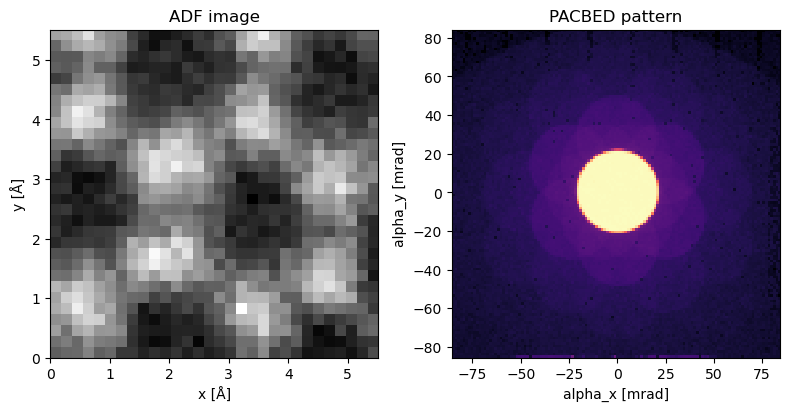

In [3]:
from abtem.measure import Calibration, Measurement
from abtem.detect import AnnularDetector
import matplotlib.pyplot as plt

calibrations  = tuple(Calibration(0., d, 'Å', name, endpoint=False) 
                        for name, d in zip(('x','y'),step_size_real_space))
calibrations += tuple(Calibration(-dk*n/2, dk, 'mrad', name, endpoint=False) 
                        for name, dk, n in zip(('alpha_x','alpha_y'),reciprocal_space_sampling_mrad,raw_data.shape[2:]))

raw_data[raw_data<adu_background_cutoff] = 0.
experimental_measurement = Measurement(raw_data,calibrations)
adf                      = AnnularDetector(inner=semiangle,outer=reciprocal_space_sampling_mrad[0]*raw_data.shape[2]/2).integrate(experimental_measurement)
pacbed                   = experimental_measurement.mean(axis=(0,1))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8,6))

adf.show(ax=ax1,title='ADF image')
pacbed.show(power=0.25,ax=ax2,cmap='magma',title='PACBED pattern')

fig.tight_layout()

We use a two-probe mixed-state reconstruction algorithm.  
We specify an ROI slightly larger than our CBED patterns (to demonstrate padding), and in contrast to the simulations above do not specify `object_px_padding` directly. Instead, the `preprocess()` method will pad by half the ROI on each side of the rotated positions.

In [12]:
from abtem.reconstruct import MixedStatePtychographicOperator

experimental_ptycho_operator = MixedStatePtychographicOperator(experimental_measurement,
                                                               region_of_interest_shape=(128,128),
                                                               num_probes=2,
                                                               semiangle_cutoff=semiangle,
                                                               energy=energy,
                                                               device='gpu',
                                                               parameters={'background_counts_cutoff': adu_background_cutoff,
                                                                           'counts_scaling_factor':adu,
                                                                           'rotation_angle':rotation_angle}).preprocess()

exp_objects, exp_probes, exp_positions, exp_sse  = experimental_ptycho_operator.reconstruct(
    max_iterations = 50,
    random_seed=1,
    return_iterations=True)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

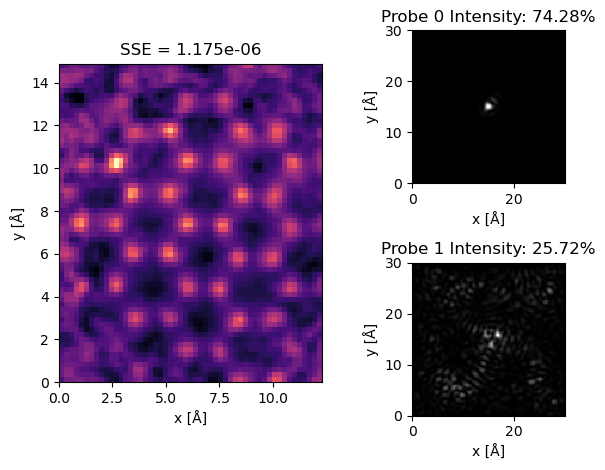

In [13]:
probe_intensity_ratios  = np.sum([probe.intensity().array for probe in exp_probes[-1]],axis=(-2,-1))
probe_intensity_ratios /= np.sum(probe_intensity_ratios)/100

fig, axd = plt.subplot_mosaic([['left', 'top-right'],['left', 'bottom-right']],constrained_layout=True)
exp_objects[-1].crop(extent=(25,27.5), origin=(12.5,12.5)).angle().show(ax=axd['left'],title=f"SSE = {float(exp_sse[-1]):.3e}",cmap='magma')
exp_probes[-1][0].intensity().show(ax=axd['top-right'],title=f'Probe 0 Intensity: {probe_intensity_ratios[0]:.2f}%')
exp_probes[-1][1].intensity().show(ax=axd['bottom-right'],title=f'Probe 1 Intensity: {probe_intensity_ratios[1]:.2f}%')
fig.tight_layout()

Indeed, this is significantly better than our ADF!